In [1]:
#udo apt-get update
#sudo apt-get install libgl1
#sudo apt-get install poppler-utils tesseract-ocr libmagic-dev

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


In [15]:
#%pip install -Uq "unstructured[all-docs]" pillow lxml pillow
#%pip install -Uq chromadb tiktoken
#%pip install -Uq langchain langchain-community langchain-openai langchain-groq
#%pip install -Uq python_dotenv

Note: you may need to restart the kernel to use updated packages.


In [1]:
import os

os.environ["GROQ_API_KEY"] = "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"
os.environ["LANGCHAIN_API_KEY"] = "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"
os.environ["LANGCHAIN_TRACING_V2"] = "true"

In [2]:
file_path = "/workspaces/RAG_LangChain/data/DT_Golondrinas.pdf"

output_path = "/workspaces/RAG_LangChain/data/"

In [ ]:
from unstructured.partition.pdf import partition_pdf


# Reference: https://docs.unstructured.io/open-source/core-functionality/chunking
chunks = partition_pdf(
    filename=file_path,
    infer_table_structure=True,            # extract tables
    strategy="hi_res",                     # mandatory to infer tables

    extract_image_block_types=["Image"],   # Add 'Table' to list to extract image of tables
    image_output_dir_path=output_path,   # if None, images and tables will saved in base64

    extract_image_block_to_payload=True,   # if true, will extract base64 for API usage

    chunking_strategy="by_title",          # or 'basic'
    max_characters=10000,                  # defaults to 500
    combine_text_under_n_chars=2000,       # defaults to 0
    new_after_n_chars=6000,

    # extract_images_in_pdf=True,          # deprecated
)

/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# separate tables from texts
tables = []
texts = []

for chunk in chunks:
    if "Table" in str(type(chunk)):
        tables.append(chunk)

    if "CompositeElement" in str(type((chunk))):
        texts.append(chunk)

In [58]:
chunk_els=chunks[0].metadata
for el in chunk_els:
    print(el)



TypeError: 'ElementMetadata' object is not iterable

In [52]:
import json


#output_path = "/workspaces/RAG_LangChain/data/chunks_docs"
output_file = "/workspaces/RAG_LangChain/data/chunks_docs/chunks_golondrinas.json"



# Función para serializar los objetos de metadatos que no son serializables por defecto
def metadata_serializer(obj):
    if hasattr(obj, 'to_dict'):
        return obj.to_dict()
    raise TypeError(f"Object of type {obj.__class__.__name__} is not JSON serializable")

# Preparar los datos para el archivo JSON
data_to_save = []
for chunk in chunks:
    chunk_data = {
        "type": chunk.__class__.__name__,
        "text": chunk.text,
        "metadata": chunk.metadata.to_dict(),
    }
    data_to_save.append(chunk_data)

# Guardar los datos en un archivo JSON
output_file = "/workspaces/RAG_LangChain/data/chunks_docs/chunks_golondrinas.json"
with open(output_file, "w", encoding="utf-8") as f:
    json.dump(data_to_save, f, ensure_ascii=False, indent=4, default=metadata_serializer)


In [8]:
# Get the images from the CompositeElement objects
def get_images_base64(chunks):
    images_b64 = []
    for chunk in chunks:
        if "CompositeElement" in str(type(chunk)):
            chunk_els = chunk.metadata.orig_elements
            for el in chunk_els:
                if "Image" in str(type(el)):
                    images_b64.append(el.metadata.image_base64)
    return images_b64

images = get_images_base64(chunks)

In [9]:
import base64
from IPython.display import Image, display

def display_base64_image(base64_code):
    # Decode the base64 string to binary
    image_data = base64.b64decode(base64_code)
    # Display the image
    display(Image(data=image_data))

#display_base64_image(images[10])

In [25]:
import fitz
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from PIL import Image

def plot_pdf_with_boxes(pdf_page, segments) :
  pix = pdf_page.get_pixmap()
  pil_image = Image.frombytes ("RGB", [pix.width, pix.height], pix.samples)
  fig, ax = plt.subplots(1, figsize=(10, 10))
  ax. imshow (pil_image)
  categories = set()
  category_to_color = {
      'Title': 'blue',
      'Image': 'green',
      'Table': 'red',
  }
  for segment in segments:
    points = segment ["coordinates"] ["points"]
    layout_width = segment ["coordinates"] ["layout_width"]
    layout_height = segment ["coordinates" ] ["layout_height"]
    scaled_points = [
        (x * pix.width / layout_width, y * pix.height / layout_height)
        for x, y in points
        ]
    box_color = category_to_color.get(segment["category"], "deepskyblue")
    categories.add(segment["category"])
    rect = patches.Polygon(scaled_points, linewidth=1, edgecolor=box_color, facecolor="none")
    ax.add_patch(rect)

  # Make legend
  legend_handles = [patches.Patch(color="deepskyblue", label="Text" )]
  for category in ["Title", "Image", "Table"]:
    if category in categories:
      legend_handles.append(
          patches.Patch(color=category_to_color[category], label=category)
      )
  ax.axis("off")
  ax.legend(handles=legend_handles, loc="upper right")
  plt.tight_layout()
  plt.show()

def render_page(doc_list: list, page_number: int, print_text=True) -> None:

  pdf_page = fitz.open (file_path). load_page (page_number - 1)
  page_docs = [
      doc for doc in doc_list if doc.metadata.get ("page_number") == page_number
  ]
  segments = [doc.metadata for doc in page_docs]
  plot_pdf_with_boxes(pdf_page, segments)
  if print_text:
    for doc in page_docs:
      print(f"{doc. page_content}\n" )

In [26]:
for i, chunk in enumerate(chunks):

  if "CompositeElement" in str(type(chunk)):
    print("\n\nChunk", i)
    for doc in chunk.metadata.orig_elements:
      print(doc.to_dict()["type"], doc.metadata.page_number)



Chunk 0
NarrativeText 1
Table 1
Title 1
UncategorizedText 1
NarrativeText 1
Title 1
Title 1
NarrativeText 1
Title 1
ListItem 1
ListItem 1
ListItem 1
NarrativeText 1
ListItem 2


Chunk 1
Title 2
ListItem 2
ListItem 2
Title 2
Title 2
NarrativeText 2
Title 2
ListItem 2
ListItem 2
ListItem 2
ListItem 2
ListItem 2
ListItem 2
ListItem 2
Title 2
ListItem 2
ListItem 2
ListItem 2
ListItem 2
NarrativeText 3
Image 3
NarrativeText 3
Title 3
Image 3
Header 4
Image 4
Header 4
UncategorizedText 4
NarrativeText 4
Title 4
NarrativeText 4
Title 4
NarrativeText 4
NarrativeText 4


Chunk 2
Title 4
Title 5
Table 5
UncategorizedText 5
UncategorizedText 5
Footer 6
Image 6
Image 6


Chunk 3
Title 7
NarrativeText 7
NarrativeText 7
NarrativeText 7


Chunk 4
Title 7
NarrativeText 7
Footer 7
UncategorizedText 7
UncategorizedText 7
UncategorizedText 8
Image 8
Header 8
NarrativeText 8
NarrativeText 8
NarrativeText 8
NarrativeText 8
NarrativeText 8
Title 8


Chunk 5
Title 9
NarrativeText 9
NarrativeText 9
Narrativ

In [27]:
chunks[1].metadata.orig_elements[0].to_dict()

{'type': 'Title',
 'element_id': 'daa45856-1cdf-406b-98ca-e0f62bcc7ed1',
 'text': 'RESUELVO:',
 'metadata': {'detection_class_prob': 0.8482891321182251,
  'coordinates': {'points': ((234.69395446777344, 680.451171875),
    (234.69395446777344, 719.3567504882812),
    (437.3888888888889, 719.3567504882812),
    (437.3888888888889, 680.451171875)),
   'system': 'PixelSpace',
   'layout_width': 1700,
   'layout_height': 2800},
  'last_modified': '2024-12-31T14:37:49',
  'filetype': 'PPM',
  'languages': ['eng'],
  'page_number': 2}}

In [28]:
from langchain_core.documents import Document

def extract_page_numbers_from_chunks(chunk):
  
  elements = chunk.metadata.orig_elements
  page_numbers = set()

  for element in elements:
    page_numbers.add(element.metadata.page_number)
  
  return page_numbers

def display_chunk_pages(chunk):
  
  
  page_numbers = extract_page_numbers_from_chunks(chunk)
  
  docs = []

  for element in chunk.metadata.orig_elements:
    metadata = element.metadata.to_dict()
    if "Table" in str(type(element)):
      metadata["category"] = "Table"
    elif "Image" in str(type(element)):
      metadata["category"] = "Image"
    else:
      metadata["category"] = "Text"

    metadata["page_number"] = element.metadata.page_number

    docs.append(Document(page_content=element.text, metadata=metadata))

  for page_number in page_numbers:
    render_page(docs, page_number, False)


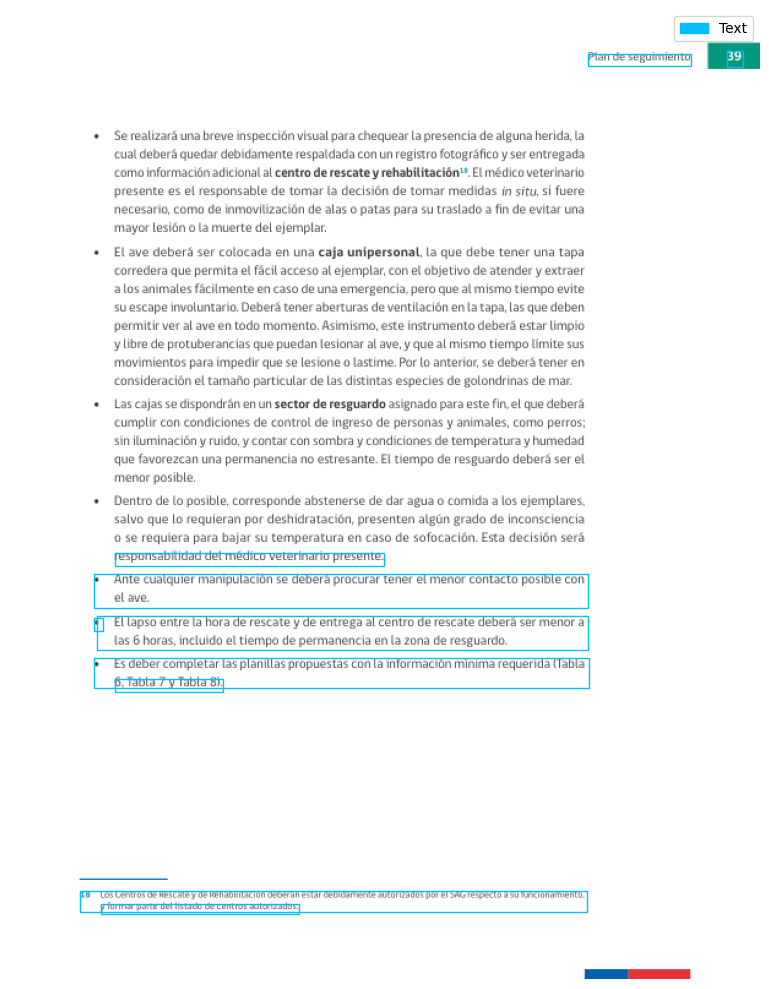

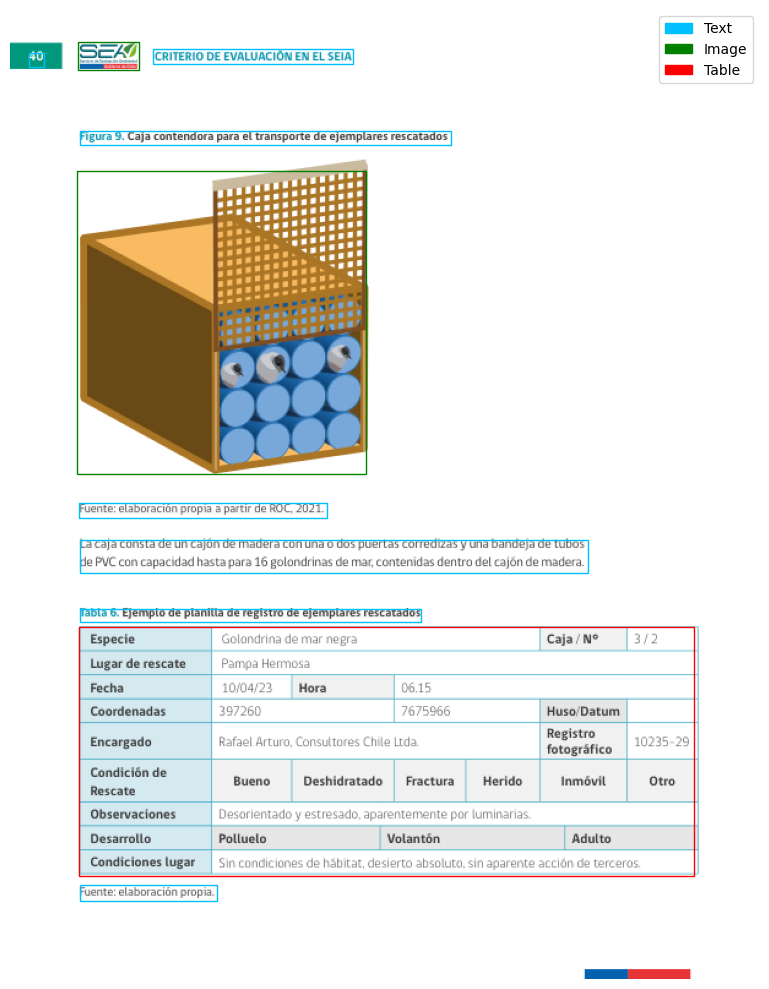

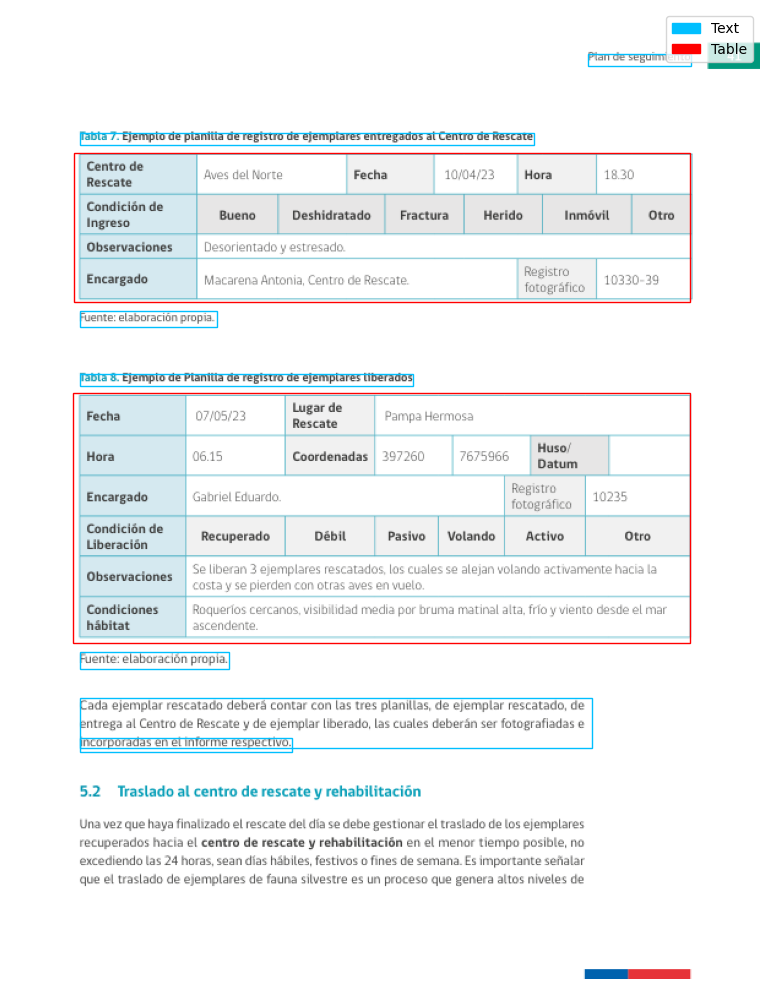

In [49]:
display_chunk_pages(chunks[29])

In [42]:
len(chunks)

35